In [43]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.fft import fft, fftfreq
from math import pi
from scipy import stats 

In [44]:
from scipy import special
from numpy import linalg as LA

In [45]:
def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

In [46]:
def generate_data(N_train = 2 ** 12, N_test = 2 ** 14): 
    
    def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

    x_train = np.random.normal(0, 1, N_train)
    y_train = f(x_train)
    
    x_validation = np.random.normal(0, 1, N_train)
    y_validation = f(x_validation)
    
    x_test = np.linspace(-25 * pi, 25 * pi, N_test).reshape(N_test, 1)
    y_test = f(x_test)
    
    plt.plot(x_test, y_test)
    plt.title('y_test')
    plt.show()
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

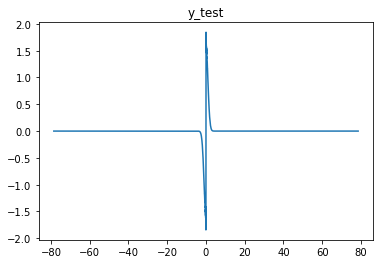

In [48]:
def Method_1_w0(x_test, y_test, px, split=0.5):
    # Finding w0 in one dimension for Method 1
    var = 0
    indices = []
    if np.shape(x_test)[1] == 1:
        N = len(y_test)
        dx = x_test[1] - x_test[0]
        dw = 1 / dx / (N - 1) * 2 * np.pi
        E_f = np.sum(px * y_test * dx)
        Y = np.fft.fft(np.sqrt(px) * (y_test - E_f), axis=0) * dx
        
        var = np.sum(np.abs(Y) ** 2) * dw / 2 / np.pi
        s = np.abs(Y[0]) ** 2 * dw/ 2 / np.pi
        
        i = 1
        # Want to find the terms that sum up to half of the variance in the fourier domain
        while s < var * split:
            s = s + 2 * np.abs(Y[i]) ** 2 * dw / 2 / np.pi
            i = i + 1
        # Check which index has the power closest to 1/2
        s1 = s
        t1 = s1 - 2 * np.abs(Y[i - 1]) ** 2 * dw / 2 / np.pi
        q1 = s1 / var
        q2 = t1 / var
        if q1 - 1 / 2 <  1 / 2 - q2:
            ind_low = np.append(np.arange(0, i), np.arange(-i + 1, 0))
            ind_high = np.arange(i, N - i + 1)
        elif q1 - 1 / 2 >=  1 / 2 - q2:
            ind_low = np.append(np.arange(0, i - 1), np.arange(-i, 0))
            ind_high = np.arange(i - 1, N - i)
        indices = {"ind_0": ind_low, "ind_1": ind_high}

    return var, indices, s

In [49]:
def Method_1(p_tot, indices, x_test, y_test, pred, px):
    E_high = 0
    E_low = 0

    # Method one in 1 dimension
    if np.shape(x_test)[1] == 1:
        dx = x_test[1] - x_test[0]
        N = len(y_test)
        dw = 1 / dx / (N - 1) * 2 * np.pi
        res = y_test - pred
        ind_low = indices["ind_0"]
        ind_high = indices["ind_1"]
        res_mean = np.sum(px * res * dx)
        Y_res = np.fft.fft(np.sqrt(px) * (res - res_mean), axis=0) * dx
        
        E_low = (1 / 2 / np.pi * dw * np.sum(np.abs(Y_res[ind_low]) ** 2)) / p_tot
        E_high = (1 / 2 / np.pi * dw * np.sum((np.abs(Y_res[ind_high])) ** 2)) / p_tot
        
    SB = (E_high - E_low) / (E_high + E_low)
    return E_low, E_high, SB

In [50]:
# Computes the Fraction of Variance Unexplained used to quantify quality of fit.
def FVU_fun(y, prediction):
    MSE = np.var(y - prediction)
    var = np.var(y)
    return MSE / var

In [51]:
import tensorflow as tf 
from tensorflow import keras 

In [52]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, 
                          hidden_layer_1,
                          hidden_layer_2, 
                          hidden_layer_3, 
                          hidden_layer_4, 
                          hidden_layer_5, 
                          output_layer])

# compling the model 
adam = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
# implement experiment 2

N_train = 2 ** 12
N_test = 2 ** 14

seed = 1
np.random.seed(seed)
x_train, y_train, x_validation, y_validation, x_test, y_test = generate_data()

# Normalize the training data
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

In [53]:
px = stats.norm.pdf(x_test, loc=0, scale=1) # write the  function 
px = np.reshape(px, (N_test,1))

var, indices, s = Method_1_w0(x_test, y_test, px)

In [54]:
class Compute_SB_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):

        # predicting the data
        x_norm = (x_test - x_mean)/x_std
        pred = model.predict(x_norm)
        pred = pred * y_std + y_mean
        pred = np.reshape(pred, (N_test, 1))
        
        E_low, E_high, SB = Method_1(var, indices, x_test, y_test, pred, px)
        FVU = FVU_fun(y_test, pred) 
        
        i = int(epoch -1)
        FVU_list[i] = FVU 
        SB_list[i] = SB 
        #print(SB)

In [55]:
N_epoch = 1000
FVU_list = np.zeros(N_epoch)
SB_list = np.zeros(N_epoch)


SB_callback = Compute_SB_Callback()
tf.random.set_seed(seed)
beta = model.fit(x_train, y_train, epochs=N_epoch, batch_size=32, callbacks=[SB_callback])

my_loss = beta.history['loss'] 

Epoch 1/1000
128/128 [==============================] - 1s 4ms/step - loss: 0.3426
Epoch 2/1000
128/128 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 3/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 4/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 5/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 6/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 7/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 8/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 9/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 10/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 11/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 12/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0011
E

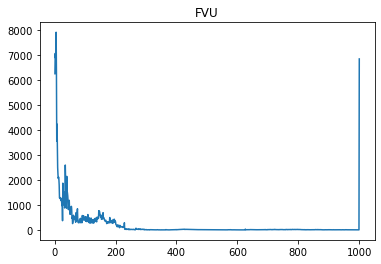

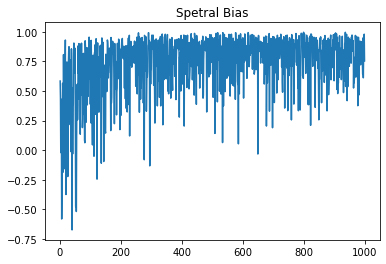

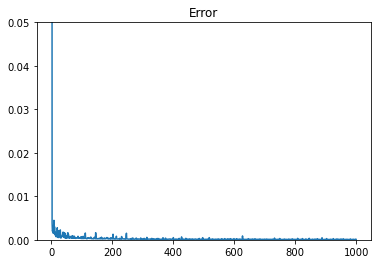

In [56]:
epoch_list = np.arange(1, N_epoch+1)

plt.plot(epoch_list, FVU_list)
#plt.ylim(0,1)
plt.title('FVU')
plt.show()

plt.plot(epoch_list, SB_list)
plt.title('Spetral Bias')
plt.show()

plt.plot(epoch_list, my_loss)
plt.title('Error')
plt.ylim(0,0.05)
plt.show()